INFO - 2022-01-29 12:18:07,853 - 3395402011 - Loading model ../../resources/networks/e34.pth
INFO - 2022-01-29 12:18:07,854 - 3395402011 - Using device cpu
INFO - 2022-01-29 12:18:07,881 - 3395402011 - Model loaded!
INFO - 2022-01-29 12:18:08,004 - 3395402011 - 
Predicting image ../../resources/images/calibrated/3d_aligned/dataset_2/1643102011.9853773.npz ...


Means: Input 0.49051496386528015 Label 0.4727116823196411 Predicted 0.4670747220516205


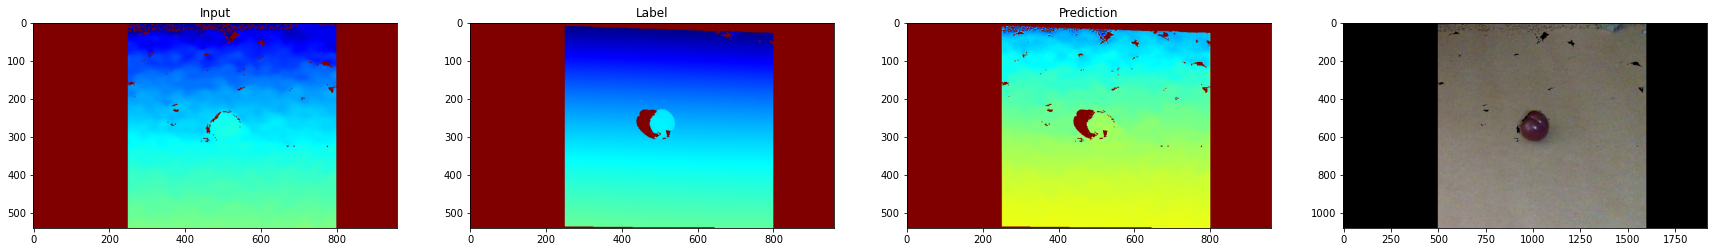

In [25]:
import argparse
import logging
from pathlib import Path
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
from calibration.calib_in_pcd import imgs_to_pcd, rs_ci
import open3d as o3d
import cv2

from utils.visualization_utils import visualize_depth, to_rgb

resource_path = Path("../../resources")

class Args:
    model = resource_path / "networks/e34.pth"
    input = resource_path / "images/calibrated/3d_aligned/dataset_2"
    scale = 0.5

args = Args()
dataset = DatasetInterface(Path(args.input))

net = UNet(n_input_channels=5, n_output_channels=1)
net = nn.DataParallel(net)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {args.model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(args.model, map_location=device))

logging.info('Model loaded!')

idx = np.random.randint(len(dataset), size=1).item()
files = dataset[idx]

logging.info(f'\nPredicting image {dataset.data_file_paths[idx]} ...')

net.eval()
rs_rgb, rs_depth, _, zv_depth = files
crop_region_mask = np.zeros((rs_rgb.shape[:2]), dtype=np.uint8)
crop_region_mask[:, 500:1600] = 1
rs_rgb = rs_rgb * crop_region_mask[..., None]
rs_depth = np.where(crop_region_mask, rs_depth, np.nan)
zv_depth = np.where(crop_region_mask, zv_depth, np.nan)

set = BasicDataset.preprocess_set(rs_rgb, rs_depth, zv_depth, args.scale, True)
img = set['image']
nan_mask = set['nan-mask']
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    pred_depths = net(img)
    pred_depth = (pred_depths * nan_mask)[0, 0].float().cpu().detach().numpy()

input_rgb = BasicDataset.resize(rs_rgb, args.scale)
input_depth = BasicDataset.resize(rs_depth, args.scale)
real_depth = BasicDataset.resize(zv_depth, args.scale)
depths = np.concatenate((input_depth, pred_depth, real_depth), axis=1)

real_depth = np.nan_to_num(real_depth)
input_depth = np.nan_to_num(input_depth)

print(f"Means: Input {np.nanmean(input_depth)} Label {np.nanmean(real_depth)} Predicted {np.mean(pred_depth)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
o3d.visualization.draw_geometries([pred_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))